# LAB 6 : Recurrent Neural Networks

Name : Vaishnavi, Joshitha

Roll Number : 180020039, 180020009

Referrence Material : 

1. https://github.com/pangolulu/rnn-from-scratch
2. https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/


#**Problem 1** : Next Token Prediction in a Sequence

Observation to be demonstrated:

1. Generate the data required
2. Represent tokens as indices using dictionaries
3. Convert the tokens into vectors using One hot encoding
4. Implement Recurrent Neural Network to solve the Next token prediction problem

##Write down the Objectives, Hypothesis and Experimental description for the above problem



Objectives : Implement RNN, and make it predict the next letter in the sequence. 

Hypothesis : The RNN should redict the next sequence. 

Experimental description : 1. Create the aprropiate dataset. 

2. Implement RNN.



3. See the predictions.


## Programming : 


1. **Representing tokens or text**

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings.

2. **One-hot encoding over vocabulary**

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [ ]:
import numpy as np


def generate_dataset(num_sequences=50):
    """
    Generates a number of sequences as our dataset.
    
    Input :
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    ## Write your code here
    
    for i in range(num_sequences): 
        num_tokens = np.random.randint(1, 10)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)

    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [ ]:
# from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Create word_to_idx and idx_to_word dictionaries for a list of sequences.
    """

    ## Write your code here
    num_sequences = len(sequences)
   # words= ['a','b', 'EOS', 'UNK']
    x = np.array(sequences[0])
    words = list(np.unique(x))
    words.append('UNK') 
    word_to_idx = {k:v for v,k in enumerate(words)}
    idx_to_word = {v:k for v,k in enumerate(words)}
    vocab_size = len(words)
    return word_to_idx, idx_to_word, num_sequences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print("Word to Index Dictionary : ",dict(word_to_idx))
print("Index to Word Dictionary : ",dict(idx_to_word))
print("Number of Sequences : ",num_sequences)
print("Vocab Size : ",vocab_size)


Word to Index Dictionary :  {'EOS': 0, 'a': 1, 'b': 2, 'UNK': 3}
Index to Word Dictionary :  {0: 'EOS', 1: 'a', 2: 'b', 3: 'UNK'}
Number of Sequences :  50
Vocab Size :  4


## Creating Dataset 

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training and test sets. 80% and 20% is a common distribution, but mind you that this largely depends on the size of the dataset. **Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.**

In [ ]:
    
def create_datasets(sequences, p_train=0.8, p_test=0.2):
    # Define partition sizes
      num_train = int(len(sequences)*p_train)
      num_test = int(len(sequences)*p_test)

      # Split sequences into partitions
      sequences_train = sequences[:num_train]
      sequences_test = sequences[-num_test:]

      def get_inputs_targets_from_sequences(sequences):
          # Define empty lists
          inputs, targets = [], []
          
          # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
          # but targets are shifted right by one so that we can predict the next word

          ## Write your code here
                  # Define empty lists
          inputs, targets = [], []
          
          # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
          # but targets are shifted right by one so that we can predict the next word
          for sequence in sequences:
              inputs.append(sequence[:-1])
              targets.append(sequence[1:])


              
          return inputs, targets

      # Get inputs and targets for each partition
      inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
      inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
      

      return inputs_train,targets_train,inputs_test,targets_test
    

x_train,y_train,x_test,y_test = create_datasets(sequences)

print("Input for the first training sample : ",x_train[0])
print("Target output for the first training sample : ",y_train[0])


Input for the first training sample :  ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
Target output for the first training sample :  ['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']


In [ ]:
len(x_train)

40

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [ ]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Input :
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Input :
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' is {test_word}.')
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' is {test_sentence}.')
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' is [0. 1. 0. 0.].
Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' is [[[0.]
  [1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]]].
Our one-hot encoding of 'a b' has shape (2, 4, 1).


## Implementation of RNN : 

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$


**Steps :** 

  1. Implement Forward Pass, Backward Pass and Optimisation
  2. Write the training loop
  3. Take care of the exploding gradient problem by clipping the gradients 

Steps: 

Forward Pass : 

1. We first multiply the input with the weights between input and hidden layers
2. Add this with the multiplication of weights in the RNN layer. This is because we want to capture the knowledge of the previous timestep
3. Pass it through a sigmoid activation function
4. Multiply this with the weights between hidden and output layers
5. At the output layer, we have a linear activation of the values so we do not explicitly pass the value through an activation layer
6. Save the state at the current layer and also the state at the previous timestep in a dictionary


Backward Pass : 

After the forward propagation step, we calculate the gradients at each layer, and backpropagate the errors. We will use truncated back propagation through time (TBPTT), instead of vanilla backprop. It may sound complex but its actually pretty straight forward.

The core difference in BPTT versus backprop is that the backpropagation step is done for all the time steps in the RNN layer. 


In [ ]:
## Write your code here

#-------------------------------Initialising Parameters-----------------------#
learning_rate = 0.0001    
nepoch = 25               
T = vocab_size   # length of sequence
hidden_dim = 70         
output_dim = vocab_size

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10


U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

#U is the weight matrix for weights between input and hidden layers
#V is the weight matrix for weights between hidden and output layers
#W is the weight matrix for shared weights in the RNN layer (hidden layer)

#-----------------------Activation Function-----------------------------#
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


#------------------Training loop-----------------------------------------------#
    # train model
loss = 0.0
n_epochs = 50
for epoch in range(n_epochs):
      for i in range(len(x_train)):
        x, y = one_hot_encode_sequence(x_train[i], vocab_size) , one_hot_encode_sequence(y_train[i], vocab_size)  
         
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(len(x)):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input[t]) #Wax
            mulw = np.dot(W, prev_s) #Waa
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
        
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(len(x)):
            dV_t = np.dot(dmulv[t], np.transpose(layers[t]['s']))  #Way : d_o , s
            dsv = np.dot(np.transpose(V), dmulv[t])  #ioutput of wax, waa to way
            
            ds = dsv
            dadd = add * (1 - add) * ds  #d_sigmoid
            
            dmulw = dadd * np.ones_like(mulw)  #d_waa

            dprev_s = np.dot(np.transpose(W), dmulw)  #


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input[t])
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW
        
        

       

        loss_per_record = sum((y - mulv)**2 / 2)
        #print(sum(loss_per_record))
        loss += loss_per_record
        #print(loss)
      print("epoch", epoch )
      loss = loss / float(y.shape[0])
      print(sum(loss))

epoch 0
[50633.19085775]
epoch 1
[45136.19159743]
epoch 2
[37266.5195054]
epoch 3
[30010.70311435]
epoch 4
[23534.65966561]
epoch 5
[17847.60207955]
epoch 6
[12950.02060039]
epoch 7
[8841.83398979]
epoch 8
[5522.38480823]
epoch 9
[2988.35641879]
epoch 10
[1228.96499766]
epoch 11
[253.05343694]
epoch 12
[28.46170926]
epoch 13
[9.52264212]
epoch 14
[7.5977324]
epoch 15
[7.38496752]
epoch 16
[7.29966948]
epoch 17
[7.28299589]
epoch 18
[7.2802859]
epoch 19
[7.27942288]
epoch 20
[7.27890299]
epoch 21
[7.27859227]
epoch 22
[7.27837328]
epoch 23
[7.27814346]
epoch 24
[7.27787391]
epoch 25
[7.2777605]
epoch 26
[7.27770694]
epoch 27
[7.27765403]
epoch 28
[7.27759881]
epoch 29
[7.27750691]
epoch 30
[7.2774307]
epoch 31
[7.27739538]
epoch 32
[7.27738978]
epoch 33
[7.27740184]
epoch 34
[7.27742385]
epoch 35
[7.27745146]
epoch 36
[7.27748229]
epoch 37
[7.27751511]
epoch 38
[7.27754929]
epoch 39
[7.27758451]
epoch 40
[7.27762063]
epoch 41
[7.27765755]
epoch 42
[7.27769524]
epoch 43
[7.2777337]
epoch

Accuracy and testing

Test Dataset

In [ ]:
output_seq = []

for i in range(len(x_test)):
        x, y = one_hot_encode_sequence(x_test[i], vocab_size) , one_hot_encode_sequence(y_test[i], vocab_size)  
        #print(x.shape,y.shape)              # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        preds = []

        for t in range(len(x)):
            mulu = np.dot(U, x[t])
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

            preds.append(mulv)
        predicted = [idx_to_word[np.argmax(o)] for o in preds]
        print("Predicted:",predicted)
        print("Actual seq :", y_test[i])
        actual = y_test
        output_seq.append(predicted) 

Predicted: ['a', 'a', 'a', 'a', 'b', 'b']
Actual seq : ['a', 'a', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a']
Actual seq : ['b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']
Predicted: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b']
Actual seq : ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b'

In [ ]:

#------Calculating WER--------------#
w_err = []
w_acc = []
for i in range(len(output_seq)):
  pred = output_seq[i]
  act = y_test[i]
  wer = 0
  wacc = 0
  for k in range(len(act)):
    if pred[k] != act[k]:
      wer = wer +1
    else:
      wacc = wacc +1
  w_err.append(wer/len(act))
  w_acc.append(wacc/len(act))


print("Total Word error Rate : ", sum(w_err)/len(w_err))
print("Total Word Accuracy : ", sum(w_acc)/len(w_acc))

Total Word error Rate :  0.49041666666666667
Total Word Accuracy :  0.5095833333333333


In [ ]:
#Train Data
output_seq = []

for i in range(len(x_train)):
        x, y = one_hot_encode_sequence(x_train[i], vocab_size) , one_hot_encode_sequence(y_train[i], vocab_size)  
        #print(x.shape,y.shape)              # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        preds = []

        for t in range(len(x)):
            mulu = np.dot(U, x[t])
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

            preds.append(mulv)
        predicted = [idx_to_word[np.argmax(o)] for o in preds]
        print("Predicted:",predicted)
        print("Actual seq :", y_train[i])
        actual = y_train
        output_seq.append(predicted) 

In [ ]:

#------Calculating WER--------------#
w_err = []
w_acc = []
for i in range(len(output_seq)):
  pred = output_seq[i]
  act = y_train[i]
  wer = 0
  wacc = 0
  for k in range(len(act)):
    if pred[k] != act[k]:
      wer = wer +1
    else:
      wacc = wacc +1
  w_err.append(wer/len(act))
  w_acc.append(wacc/len(act))


print("Total Word error Rate : ", sum(w_err)/len(w_err))
print("Total Word Accuracy : ", sum(w_acc)/len(w_acc))

Total Word error Rate :  0.3663095238095238
Total Word Accuracy :  0.6336904761904761


## Inferences and Conclusion : State all the key observations and conclusion

The word error rate on train data set : 36.6%, with accuracy being 63.3%.

The word error rate on test data set : 49%, with accuracy being 50%.


#**Problem 2** : Demonstrate the same for a Sine Wave

Objective : Given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series.

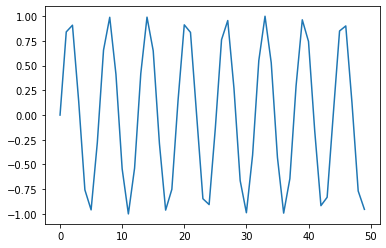

In [ ]:
## Write your code here
import math
import matplotlib.pyplot as plt
import numpy as np
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])


In [ ]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

print(X.shape, Y.shape)

(100, 50, 1) (100, 1)


In [ ]:
## Write your code here

#-------------------------------Initialising Parameters-----------------------#
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10


U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

#U is the weight matrix for weights between input and hidden layers
#V is the weight matrix for weights between hidden and output layers
#W is the weight matrix for shared weights in the RNN layer (hidden layer)

#-----------------------Activation Function-----------------------------#
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


#------------------Training loop-----------------------------------------------#
    # train model

#n_epochs = 50
for epoch in range(nepoch):
      loss = 0.0
      for i in range(Y.shape[0]):
        x, y = X[i], Y[i]  
         
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
        
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW
        
        

       

        loss_per_record = (y - mulv)**2 / 2
        #print(sum(loss_per_record))
        loss += loss_per_record
        #print(loss)
      print("epoch", epoch )
      loss = loss / float(y.shape[0])
      print(loss)

epoch 0
[[94126.89734992]]
epoch 1
[[55839.36038095]]
epoch 2
[[27551.822133]]
epoch 3
[[9254.10206085]]
epoch 4
[[845.07433134]]
epoch 5
[[30.44707334]]
epoch 6
[[29.81711196]]
epoch 7
[[29.42851762]]
epoch 8
[[29.47807824]]
epoch 9
[[29.79429852]]
epoch 10
[[29.64926909]]
epoch 11
[[29.32282008]]
epoch 12
[[29.17018649]]
epoch 13
[[29.55426131]]
epoch 14
[[29.25508561]]
epoch 15
[[29.25585322]]
epoch 16
[[29.1329578]]
epoch 17
[[29.16656343]]
epoch 18
[[29.43163957]]
epoch 19
[[29.33591695]]
epoch 20
[[29.57998306]]
epoch 21
[[29.33619216]]
epoch 22
[[29.44406575]]
epoch 23
[[29.16238753]]
epoch 24
[[29.06837093]]


In [ ]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)


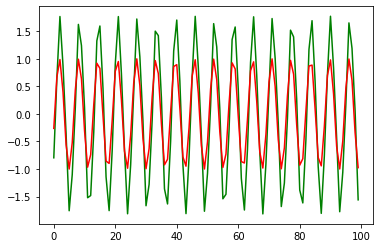

In [ ]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()


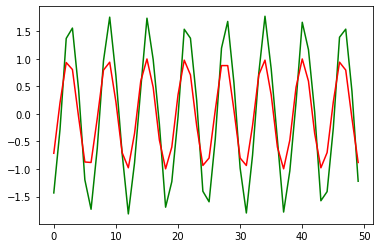

In [ ]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()
